# EDA de Visión por Computador — **INSPECTOR DE PANALES**
**Proyecto integrador – Análisis Exploratorio de Datos (EDA)**  

Soportado:
- **Clasificación por carpetas** (`data/clase_a/*.jpg`, `data/clase_b/*.jpg`, ...)
- **Detección** estilo **YOLO** (`data/images/*.jpg`, `data/labels/*.txt` con `x_center y_center width height` normalizados)
- **Segmentación** (`data/images/*.jpg`, `data/masks/*.png` con máscaras binarias o por clase)

Librerías: `numpy`, `pandas`, `matplotlib`, `opencv-python`, `Pillow`, `scikit-image` y opcionalmente `imagehash`, `torch/torchvision` para embeddings.


## 0. (Opcional) Montar Google Drive en Colab
Descomenta si trabajas en Google Colab y tus datos están en Drive.

In [1]:
# Paso 1: Montar Google Drive para acceder al dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

origen = '/content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01'
clases_disponibles = [d for d in os.listdir(origen) if os.path.isdir(os.path.join(origen, d))]
print("Clases disponibles:")
print(clases_disponibles)

Clases disponibles:
['NG_tipo2', 'NG_tipo1', 'NG_tipo3', 'OK_tipo1', 'OK_tipo2', 'OK_tipo3', 'dataset']


## 1. Creacion ruta dataset / Preparacion 20/80 Entrenamiento
Preparar rutas y dataset con validaciones y partición dinámica

In [3]:
import shutil
import os

# Ruta donde se crea el dataset
drive_base_path = '/content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01'
dataset_dir = os.path.join(drive_base_path, 'dataset')

# Eliminar la carpeta 'dataset' completa si ya existe
if os.path.exists(dataset_dir):
    print(f"🧹 Eliminando dataset anterior en: {dataset_dir}")
    shutil.rmtree(dataset_dir)
else:
    print("✅ No hay dataset previo, limpio para comenzar.")

# Crear nuevamente las carpetas vacías
os.makedirs(os.path.join(dataset_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "test"), exist_ok=True)

print("📁 Dataset limpio y preparado en:")
print(f"  - Train: {os.path.join(dataset_dir, 'train')}")
print(f"  - Test:  {os.path.join(dataset_dir, 'test')}")


🧹 Eliminando dataset anterior en: /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset
📁 Dataset limpio y preparado en:
  - Train: /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/train
  - Test:  /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/test


In [4]:
# Preparar rutas y dataset con validaciones y partición dinámica
import os
from glob import glob
import shutil

# Esta es la carpeta donde están las clases directamente
drive_base_path = '/content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01'
os.makedirs(drive_base_path, exist_ok=True)

# Aquí se guardará el dataset procesado (train/test)
dataset_dir = os.path.join(drive_base_path, 'dataset')

def preparar_dataset(origen, destino_base, clases, max_img=100, test_ratio=0.2):
    train_path = os.path.join(destino_base, "train")
    test_path = os.path.join(destino_base, "test")
    for path in [train_path, test_path]:
        os.makedirs(path, exist_ok=True)

    for cls in clases:
        carpeta_origen = os.path.join(origen, cls)
        if not os.path.exists(carpeta_origen):
            print(f"⚠️ Carpeta no encontrada: {carpeta_origen}")
            continue

        imagenes = sorted(glob(os.path.join(carpeta_origen, "*.jpg")))
        total_disponibles = len(imagenes)

        if total_disponibles == 0:
            print(f"⚠️ No se encontraron imágenes para la clase '{cls}'")
            continue

        # Seleccionar hasta max_img, o todas si hay menos
        imagenes = imagenes[:max_img]
        n_total = len(imagenes)
        n_test = max(1, int(n_total * test_ratio))  # al menos 1 imagen para test
        n_train = n_total - n_test

        os.makedirs(os.path.join(train_path, cls), exist_ok=True)
        os.makedirs(os.path.join(test_path, cls), exist_ok=True)

        for i, img in enumerate(imagenes):
            destino = test_path if i >= n_train else train_path
            shutil.copy(img, os.path.join(destino, cls, os.path.basename(img)))

        print(f"✅ Clase '{cls}': {n_train} train / {n_test} test (de {n_total} imágenes disponibles)")

    return train_path, test_path

# Clases que queremos usar (verifica que existan antes)
clases = ["NG_tipo1", "NG_tipo2", "NG_tipo3", "OK_tipo1", "OK_tipo2", "OK_tipo3"]


# Corrección de la ruta de origen
base_origen = drive_base_path
train_dir, test_dir = preparar_dataset(base_origen, dataset_dir, clases)


✅ Clase 'NG_tipo1': 8 train / 2 test (de 10 imágenes disponibles)
✅ Clase 'NG_tipo2': 8 train / 2 test (de 10 imágenes disponibles)
✅ Clase 'NG_tipo3': 8 train / 2 test (de 10 imágenes disponibles)
✅ Clase 'OK_tipo1': 20 train / 4 test (de 24 imágenes disponibles)
✅ Clase 'OK_tipo2': 20 train / 5 test (de 25 imágenes disponibles)
✅ Clase 'OK_tipo3': 16 train / 4 test (de 20 imágenes disponibles)


## 2. Visualización de imágenes por clase


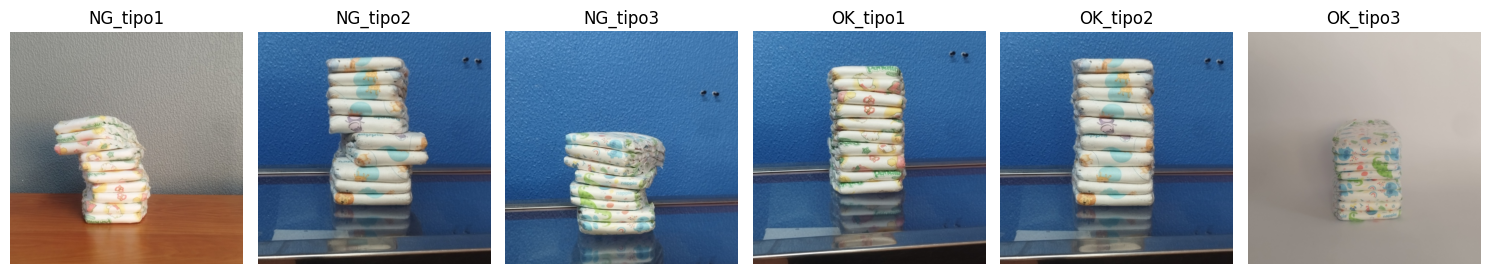

In [5]:
# Visualización de imágenes por clase


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import os

def mostrar_imagenes_test(test_path, clases):
    fig, axs = plt.subplots(1, len(clases), figsize=(15, 3))
    for i, cls in enumerate(clases):
        ruta_imagenes = glob(os.path.join(test_path, cls, "*.jpg"))
        if ruta_imagenes:
            img = mpimg.imread(ruta_imagenes[0])
            axs[i].imshow(img)
            axs[i].set_title(cls)
            axs[i].axis("off")
        else:
            axs[i].text(0.5, 0.5, f"No image\nfor {cls}", ha='center', va='center')
            axs[i].set_title(cls)
            axs[i].axis("off")
    plt.tight_layout()
    plt.show()


mostrar_imagenes_test(test_dir, clases)

## 3. Importación de librerías

In [6]:
import os, math, itertools, warnings
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image, ImageStat

try:
    import imagehash
except Exception:
    imagehash = None
    warnings.warn("imagehash no disponible; duplicados por pHash deshabilitado.")

# Embeddings opcionales
try:
    import torch, torchvision
    from torchvision import transforms
except Exception:
    torch = None
    torchvision = None

pd.set_option("display.max_columns", 50)

def show(title):
    print(f"\n=== {title} ===")


/tmp/ipython-input-3721633909.py:16: UserWarning: imagehash no disponible; duplicados por pHash deshabilitado.
  warnings.warn("imagehash no disponible; duplicados por pHash deshabilitado.")


## 4. Funciones utilitarias comunes

In [7]:

def list_images(dir_path: Path, class_from_parent=True):
    files = []
    for root, dirs, fns in os.walk(dir_path):
        for fn in fns:
            ext = os.path.splitext(fn)[1].lower()
            if ext in IMG_EXTS:
                p = Path(root)/fn
                label = Path(root).name if class_from_parent else None
                files.append((str(p), label))
    return pd.DataFrame(files, columns=["filepath","label"])

def basic_image_stats(path):
    try:
        with Image.open(path) as im:
            im_rgb = im.convert("RGB")
            w, h = im_rgb.size
            aspect = w/h if h else np.nan
            fsize = os.path.getsize(path)
            stat = ImageStat.Stat(im_rgb)
            mean_r, mean_g, mean_b = stat.mean
            brightness = 0.2126*mean_r + 0.7152*mean_g + 0.0722*mean_b
    except Exception:
        w = h = aspect = fsize = mean_r = mean_g = mean_b = brightness = np.nan

    # blur (var. Laplaciano)
    try:
        img_cv = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        if img_cv is None:
            img_cv = cv2.cvtColor(np.array(Image.open(path).convert("RGB")), cv2.COLOR_RGB2GRAY)
        blur = cv2.Laplacian(img_cv, cv2.CV_64F).var()
    except Exception:
        blur = np.nan

    ph = None
    if imagehash is not None:
        try:
            with Image.open(path) as im:
                ph = str(imagehash.phash(im))
        except Exception:
            ph = None

    return w, h, aspect, fsize, mean_r, mean_g, mean_b, brightness, blur, ph


## 5A. Pipeline CLASIFICACIÓN (si `MODE='classification'`)

In [21]:
# Definir variables necesarias
MODE = "classification"  # Puedes cambiar a "detection" si es necesario
IMAGE_DIR = train_dir # o test_dir dependiendo de si quieres analizar el conjunto de entrenamiento o prueba
CLASS_FROM_PARENT = True # True si el nombre de la clase está en el nombre de la carpeta padre

# Definir extensiones de imagen válidas
IMG_EXTS = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]


=== Exploración inicial ===
Total de imágenes: 80


,filepath,label,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash
0,/content/drive/MyDrive/Proyecto Final Maestria...,NG_tipo1,640,640,1.0,58761,175.354778,165.320083,155.790198,166.765401,32.886587,None
1,/content/drive/MyDrive/Proyecto Final Maestria...,NG_tipo1,640,640,1.0,61672,176.718542,166.378843,156.724167,167.879995,34.523157,None
2,/content/drive/MyDrive/Proyecto Final Maestria...,NG_tipo1,640,640,1.0,59847,177.415769,166.435310,156.969580,168.086330,32.723040,None
3,/content/drive/MyDrive/Proyecto Final Maestria...,NG_tipo1,640,640,1.0,61135,173.885386,163.182036,154.662358,164.842448,46.404414,None
4,/content/drive/MyDrive/Proyecto Final Maestria...,NG_tipo1,640,640,1.0,60574,173.334446,163.868684,154.643420,165.215041,35.123552,None


,filepath,label,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash
count,80,80,80.000000,80.0,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,0
unique,80,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
top,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,638.000000,640.0,0.996875,86449.075000,155.225392,149.085875,143.070747,149.956844,58.315561,NaN
std,NaN,NaN,17.888544,0.0,0.027951,33979.764564,27.718634,16.973453,14.667886,18.250129,40.139661,NaN
min,NaN,NaN,480.000000,640.0,0.750000,41512.000000,73.056628,106.734712,117.706089,101.971209,11.404858,NaN
25%,NaN,NaN,640.000000,640.0,1.000000,58791.000000,149.801732,136.046843,126.678857,137.564281,31.041429,NaN
50%,NaN,NaN,640.000000,640.0,1.000000,62497.000000,167.596895,157.500791,150.324977,159.260867,40.736577,NaN
75%,NaN,NaN,640.000000,640.0,1.000000,124930.750000,172.230848,163.512297,154.993022,164.810960,93.188066,NaN



=== Balance de clases ===


,count
label,
OK_tipo2,20
OK_tipo1,20
OK_tipo3,16
NG_tipo1,8
NG_tipo2,8
NG_tipo3,8


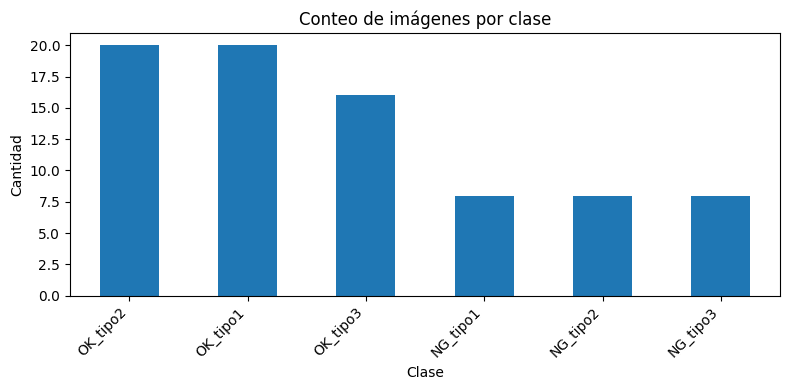

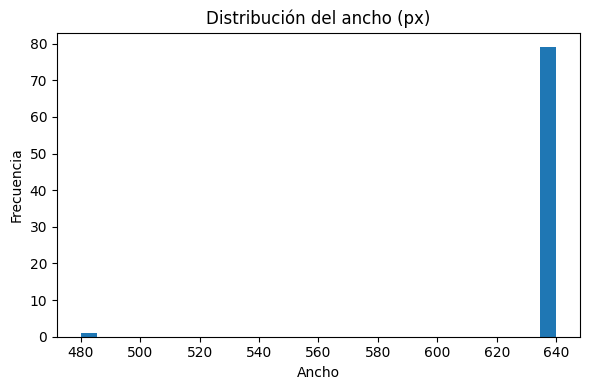

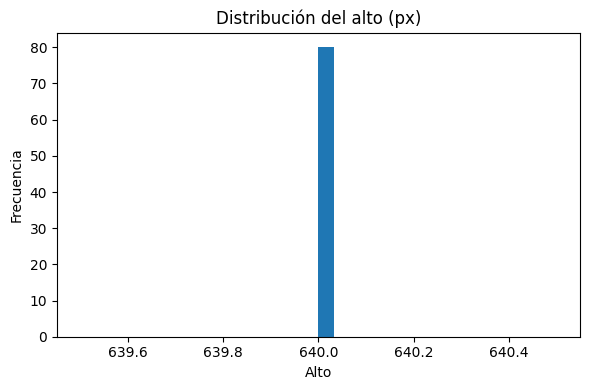

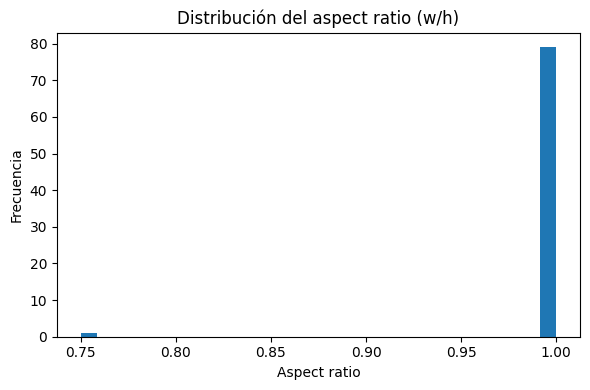

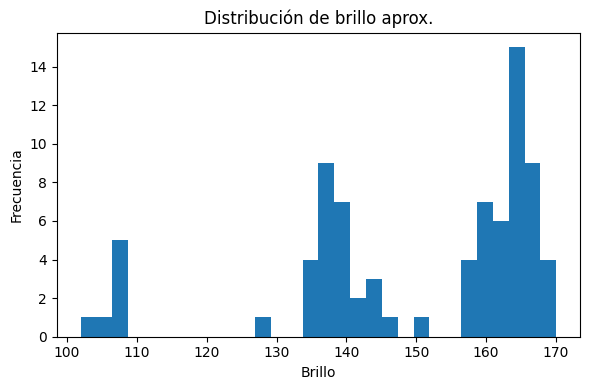

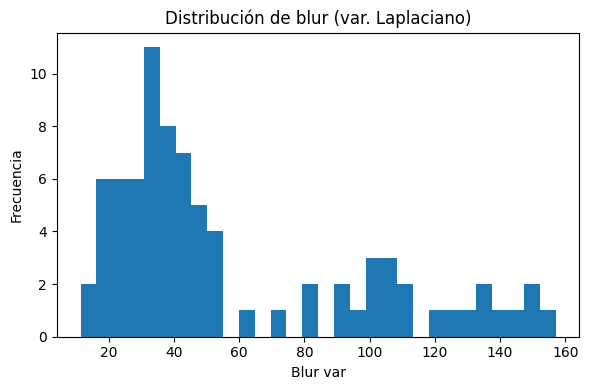

<Figure size 600x400 with 0 Axes>

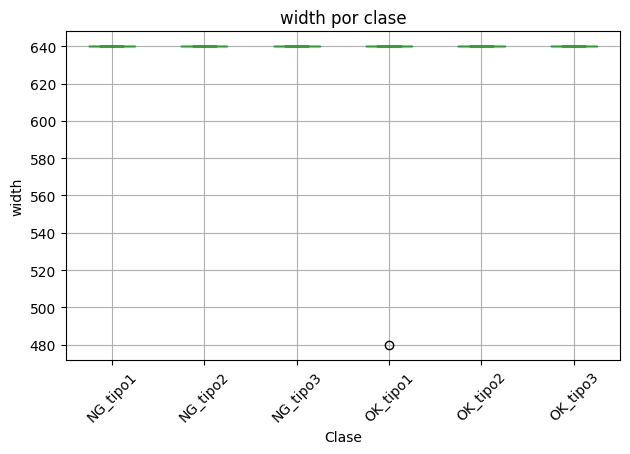

<Figure size 600x400 with 0 Axes>

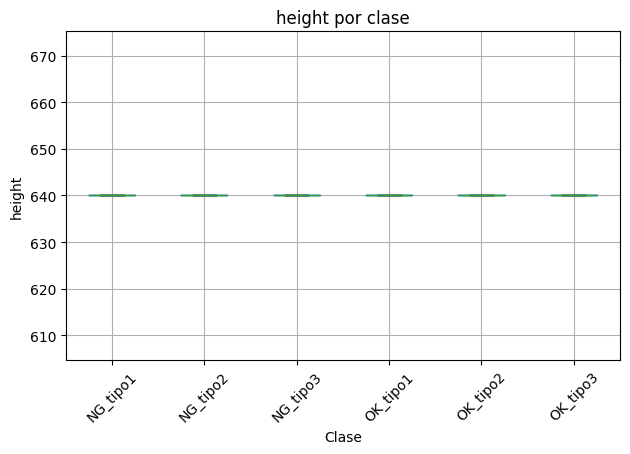


=== Matriz de correlación ===


,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var
width,1.000000,NaN,1.000000,0.149728,-0.097725,-0.128042,-0.133753,-0.124486,0.035331
height,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aspect_ratio,1.000000,NaN,1.000000,0.149728,-0.097725,-0.128042,-0.133753,-0.124486,0.035331
file_size,0.149728,NaN,0.149728,1.000000,-0.719998,-0.876641,-0.735850,-0.858303,0.896849
mean_r,-0.097725,NaN,-0.097725,-0.719998,1.000000,0.912014,0.258419,0.944540,-0.731635
mean_g,-0.128042,NaN,-0.128042,-0.876641,0.912014,1.000000,0.627783,0.996088,-0.778995
mean_b,-0.133753,NaN,-0.133753,-0.735850,0.258419,0.627783,1.000000,0.559054,-0.479143
brightness,-0.124486,NaN,-0.124486,-0.858303,0.944540,0.996088,0.559054,1.000000,-0.782213
blur_var,0.035331,NaN,0.035331,0.896849,-0.731635,-0.778995,-0.479143,-0.782213,1.000000


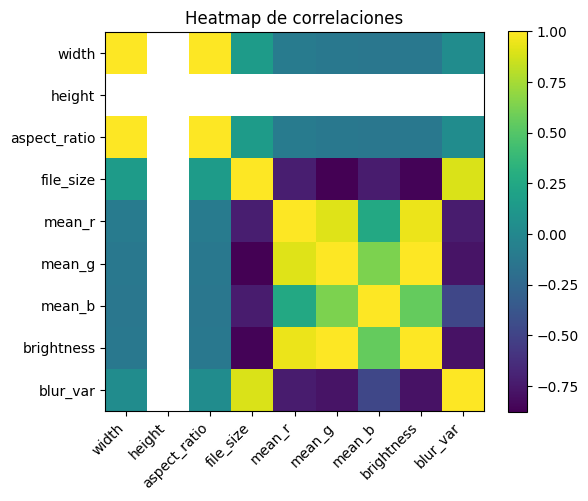


=== Detección de anomalías ===
Borrosas (<=p5=17.58): 4


,filepath,label,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash
18,/content/drive/MyDrive/Proyecto Final Maestria...,NG_tipo3,640,640,1.0,56394,170.780037,163.686797,155.969243,164.637612,11.404858,None
44,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo2,640,640,1.0,58216,159.762991,149.576616,143.521052,151.305028,16.641514,None
49,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo2,640,640,1.0,61047,167.358308,158.491226,150.123721,159.772233,16.809121,None
52,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo2,640,640,1.0,70207,142.570684,133.858152,126.644924,135.189641,13.307004,None


Oscuras (<=p5=107.5): 4 | Sobreexpuestas (>=p95=167.6): 4


,filepath,label,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash
72,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo3,640,640,1.0,130107,74.776465,110.484255,146.442244,105.488946,109.928969,None
73,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo3,640,640,1.0,129901,73.238125,106.734712,139.392214,101.971209,124.101477,None
76,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo3,640,640,1.0,142986,73.056628,112.603740,149.556968,106.864047,147.817380,None
77,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo3,640,640,1.0,141799,73.638081,111.930266,149.911838,106.531617,146.788471,None


,filepath,label,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash
1,/content/drive/MyDrive/Proyecto Final Maestria...,NG_tipo1,640,640,1.00,61672,176.718542,166.378843,156.724167,167.879995,34.523157,None
2,/content/drive/MyDrive/Proyecto Final Maestria...,NG_tipo1,640,640,1.00,59847,177.415769,166.435310,156.969580,168.086330,32.723040,None
24,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo1,480,640,0.75,41512,179.150905,168.281582,160.398887,170.023269,45.789466,None
28,/content/drive/MyDrive/Proyecto Final Maestria...,OK_tipo1,640,640,1.00,60166,176.626201,167.896260,158.152290,169.048731,45.273403,None



=== Conclusiones e insights ===
Resumen: {'total_imagenes': 80, 'clases': ['NG_tipo1', 'NG_tipo2', 'NG_tipo3', 'OK_tipo1', 'OK_tipo2', 'OK_tipo3'], 'min_dim': (480, 640), 'max_dim': (640, 640), 'aspect_ratio_range': (0.75, 1.0)}
Sugerencias:
- Redimensionar a tamaño estándar (p.ej., 224x224) con padding si se requiere conservar el aspect ratio.
- Normalizar canales RGB (mean/std del dataset).
- Augmentations según variabilidad observada (rotación, recorte, cambios de brillo/contraste).
- Manejar desbalance de clases con oversampling o ponderación de la pérdida.
- Filtrar o revisar borrosas/duplicadas/sobreexpuestas.



In [22]:

if MODE == "classification":
    df = list_images(IMAGE_DIR, class_from_parent=CLASS_FROM_PARENT)
    stats = df["filepath"].apply(basic_image_stats)
    cols = ["width","height","aspect_ratio","file_size","mean_r","mean_g","mean_b","brightness","blur_var","phash"]
    df = pd.concat([df, pd.DataFrame(stats.tolist(), columns=cols)], axis=1)

    show("Exploración inicial")
    print("Total de imágenes:", len(df))
    display(df.head())
    display(df.describe(include="all"))

    if "label" in df.columns and df["label"].notna().any():
        show("Balance de clases")
        class_counts = df["label"].value_counts().sort_values(ascending=False)
        display(class_counts.to_frame("count"))
        plt.figure(figsize=(8,4))
        class_counts.plot(kind="bar")
        plt.title("Conteo de imágenes por clase")
        plt.xlabel("Clase"); plt.ylabel("Cantidad")
        plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

    # Dimensiones y calidad
    for col, ttl, xlab in [
        ("width","Distribución del ancho (px)","Ancho"),
        ("height","Distribución del alto (px)","Alto"),
        ("aspect_ratio","Distribución del aspect ratio (w/h)","Aspect ratio"),
        ("brightness","Distribución de brillo aprox.","Brillo"),
        ("blur_var","Distribución de blur (var. Laplaciano)","Blur var")
    ]:
        plt.figure(figsize=(6,4))
        plt.hist(df[col].dropna(), bins=30)
        plt.title(ttl); plt.xlabel(xlab); plt.ylabel("Frecuencia")
        plt.tight_layout(); plt.show()

    # Bivariado por clase
    if "label" in df.columns and df["label"].notna().any():
        for col in ["width","height"]:
            plt.figure(figsize=(6,4))
            df.boxplot(column=col, by="label", rot=45)
            plt.title(f"{col} por clase"); plt.suptitle(""); plt.xlabel("Clase"); plt.ylabel(col)
            plt.tight_layout(); plt.show()

    # Correlaciones numéricas
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 1:
        corr = df[num_cols].corr()
        show("Matriz de correlación")
        display(corr)
        fig, ax = plt.subplots(figsize=(6,5))
        cax = ax.imshow(corr, interpolation='nearest')
        ax.set_title("Heatmap de correlaciones")
        ax.set_xticks(range(len(num_cols))); ax.set_yticks(range(len(num_cols)))
        ax.set_xticklabels(num_cols, rotation=45, ha="right"); ax.set_yticklabels(num_cols)
        fig.colorbar(cax); plt.tight_layout(); plt.show()

    # Anomalías: duplicados, borrosas, brillo extremo, inválidas
    show("Detección de anomalías")
    if imagehash is not None and "phash" in df.columns:
        ph_counts = df["phash"].value_counts()
        dup_hashes = ph_counts[ph_counts>1].index.tolist()
        dup_df = df[df["phash"].isin(dup_hashes)].sort_values("phash")
        print("Posibles duplicados pHash:", len(dup_df))
        display(dup_df.head(20))

    if "blur_var" in df.columns and df["blur_var"].notna().any():
        p5 = np.nanpercentile(df["blur_var"], 5)
        blurry = df[df["blur_var"]<=p5]
        print(f"Borrosas (<=p5={p5:.2f}):", len(blurry)); display(blurry.head(10))

    if "brightness" in df.columns and df["brightness"].notna().any():
        low_b = np.nanpercentile(df["brightness"], 5)
        high_b = np.nanpercentile(df["brightness"], 95)
        too_dark = df[df["brightness"]<=low_b]; too_bright = df[df["brightness"]>=high_b]
        print(f"Oscuras (<=p5={low_b:.1f}): {len(too_dark)} | Sobreexpuestas (>=p95={high_b:.1f}): {len(too_bright)}")
        display(too_dark.head(5)); display(too_bright.head(5))

    invalid = df[df["width"].isna() | df["height"].isna()]
    if len(invalid):
        print("Inválidas/corruptas:", len(invalid)); display(invalid.head(10))

    # Resumen
    show("Conclusiones e insights")
    summary = {
        "total_imagenes": int(len(df)),
        "clases": list(df["label"].dropna().unique()) if "label" in df.columns else None,
        "min_dim": (int(df["width"].min()), int(df["height"].min())) if df["width"].notna().any() else None,
        "max_dim": (int(df["width"].max()), int(df["height"].max())) if df["width"].notna().any() else None,
        "aspect_ratio_range": (float(df["aspect_ratio"].min()), float(df["aspect_ratio"].max())) if df["aspect_ratio"].notna().any() else None,
    }
    print("Resumen:", summary)
    print("""Sugerencias:
- Redimensionar a tamaño estándar (p.ej., 224x224) con padding si se requiere conservar el aspect ratio.
- Normalizar canales RGB (mean/std del dataset).
- Augmentations según variabilidad observada (rotación, recorte, cambios de brillo/contraste).
- Manejar desbalance de clases con oversampling o ponderación de la pérdida.
- Filtrar o revisar borrosas/duplicadas/sobreexpuestas.
""")


Generados de reporte 1

In [23]:
%pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.1 MB/s eta 0:00:00


In [25]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import io

def generate_classification_report_pdf(df, class_counts, corr, blurry, too_dark, too_bright, invalid, summary, filename="classification_report.pdf"):
    c = canvas.Canvas(filename, pagesize=letter)
    width, height = letter

    # Title Page
    c.drawString(100, height - 100, "Classification Mode EDA Report")
    c.drawString(100, height - 120, "Generated from Google Colab Notebook")
    c.drawString(100, height - 140, f"Total Images Analyzed: {summary.get('total_imagenes', 'N/A')}")
    c.drawString(100, height - 160, f"Classes: {', '.join(summary.get('clases', ['N/A']))}")
    c.showPage()

    # Initial Exploration
    c.drawString(100, height - 100, "1. Initial Exploration")
    c.drawString(100, height - 120, f"Total Images: {len(df)}")

    # Convert head of dataframe to string and add to PDF
    df_head_str = df.head().to_string()
    textobject = c.beginText(100, height - 140)
    textobject.textLines(df_head_str)
    c.drawText(textobject)
    c.showPage()


    # Class Balance
    c.drawString(100, height - 100, "2. Class Balance")
    class_counts_str = class_counts.to_frame("count").to_string()
    textobject = c.beginText(100, height - 120)
    textobject.textLines(class_counts_str)
    c.drawText(textobject)

    # Add class balance plot image
    img_buf = io.BytesIO()
    plt.figure(figsize=(8, 4))
    class_counts.plot(kind="bar")
    plt.title("Image Count by Class")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(img_buf, format='png')
    plt.close()
    img_buf.seek(0)
    img = ImageReader(img_buf)
    c.drawImage(img, 100, height - 450, width=400, height=200)
    c.showPage()

    # Dimensions and Quality
    c.drawString(100, height - 100, "3. Dimensions and Quality Distributions")
    plots_to_add = [
        ("width", "Distribution of Width (px)", "Width"),
        ("height", "Distribution of Height (px)", "Height"),
        ("aspect_ratio", "Distribution of Aspect Ratio (w/h)", "Aspect ratio"),
        ("brightness", "Distribution of Approx. Brightness", "Brightness"),
        ("blur_var", "Distribution of Blur (Laplacian var.)", "Blur var")
    ]

    y_offset = height - 120
    for col, ttl, xlab in plots_to_add:
        img_buf = io.BytesIO()
        plt.figure(figsize=(6, 4))
        plt.hist(df[col].dropna(), bins=30)
        plt.title(ttl)
        plt.xlabel(xlab)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(img_buf, format='png')
        plt.close()
        img_buf.seek(0)
        img = ImageReader(img_buf)
        c.drawImage(img, 100, y_offset - 200, width=300, height=200)
        y_offset -= 220
        if y_offset < 150: # Check if enough space for the next plot
            c.showPage()
            y_offset = height - 100
            c.drawString(100, height - 100, f"3. Dimensions and Quality Distributions (Cont.)")


    # Bivariate by Class
    if "label" in df.columns and df["label"].notna().any():
        c.showPage()
        c.drawString(100, height - 100, "4. Bivariate Analysis by Class")
        y_offset = height - 120
        for col in ["width", "height"]:
            img_buf = io.BytesIO()
            plt.figure(figsize=(6, 4))
            df.boxplot(column=col, by="label", rot=45)
            plt.title(f"{col} by Class")
            plt.suptitle("") # Suppress the default suptitle
            plt.xlabel("Class")
            plt.ylabel(col)
            plt.tight_layout()
            plt.savefig(img_buf, format='png')
            plt.close()
            img_buf.seek(0)
            img = ImageReader(img_buf)
            c.drawImage(img, 100, y_offset - 200, width=300, height=200)
            y_offset -= 220


    # Correlations
    if not corr.empty and len(corr.columns) > 1:
        c.showPage()
        c.drawString(100, height - 100, "5. Correlation Matrix")
        corr_str = corr.to_string()
        textobject = c.beginText(100, height - 120)
        textobject.textLines(corr_str)
        c.drawText(textobject)

        # Add correlation heatmap
        img_buf = io.BytesIO()
        fig, ax = plt.subplots(figsize=(6, 5))
        cax = ax.imshow(corr, interpolation='nearest')
        ax.set_title("Correlation Heatmap")
        ax.set_xticks(range(len(corr.columns)))
        ax.set_yticks(range(len(corr.columns)))
        ax.set_xticklabels(corr.columns, rotation=45, ha="right")
        ax.set_yticklabels(corr.columns)
        fig.colorbar(cax)
        plt.tight_layout()
        plt.savefig(img_buf, format='png')
        plt.close()
        img_buf.seek(0)
        img = ImageReader(img_buf)
        c.drawImage(img, 100, height - 450, width=300, height=250)
        c.showPage()


    # Anomalies
    c.drawString(100, height - 100, "6. Anomaly Detection")
    y_offset = height - 120

    if imagehash is not None and "phash" in df.columns:
        c.drawString(100, y_offset, "Possible Duplicates (pHash):")
        y_offset -= 20
        if not dup_df.empty:
            dup_df_str = dup_df.head(20).to_string()
            textobject = c.beginText(100, y_offset)
            textobject.textLines(dup_df_str)
            c.drawText(textobject)
            y_offset = textobject.getY() # Get the current y position of the textobject
        else:
             c.drawString(100, y_offset, "None found.")
             y_offset -= 20
        y_offset -= 20 # Add space after this section


    if "blur_var" in df.columns and df["blur_var"].notna().any():
        c.drawString(100, y_offset, f"Blurry (<=p5={np.nanpercentile(df['blur_var'], 5):.2f}): {len(blurry)}")
        y_offset -= 20
        if not blurry.empty:
            blurry_str = blurry.head(10).to_string()
            textobject = c.beginText(100, y_offset)
            textobject.textLines(blurry_str)
            c.drawText(textobject)
            y_offset = textobject.getY()
        else:
            c.drawString(100, y_offset, "None found.")
            y_offset -= 20
        y_offset -= 20


    if "brightness" in df.columns and df["brightness"].notna().any():
        low_b = np.nanpercentile(df["brightness"], 5)
        high_b = np.nanpercentile(df["brightness"], 95)
        c.drawString(100, y_offset, f"Dark (<=p5={low_b:.1f}): {len(too_dark)}")
        y_offset -= 20
        if not too_dark.empty:
            too_dark_str = too_dark.head(5).to_string()
            textobject = c.beginText(100, y_offset)
            textobject.textLines(too_dark_str)
            c.drawText(textobject)
            y_offset = textobject.getY()
        else:
            c.drawString(100, y_offset, "None found.")
            y_offset -= 20
        y_offset -= 10

        c.drawString(100, y_offset, f"Overexposed (>=p95={high_b:.1f}): {len(too_bright)}")
        y_offset -= 20
        if not too_bright.empty:
            too_bright_str = too_bright.head(5).to_string()
            textobject = c.beginText(100, y_offset)
            textobject.textLines(too_bright_str)
            c.drawText(textobject)
            y_offset = textobject.getY()
        else:
             c.drawString(100, y_offset, "None found.")
             y_offset -= 20
        y_offset -= 20


    if not invalid.empty:
        c.drawString(100, y_offset, f"Invalid/Corrupted: {len(invalid)}")
        y_offset -= 20
        invalid_str = invalid.head(10).to_string()
        textobject = c.beginText(100, y_offset)
        textobject.textLines(invalid_str)
        c.drawText(textobject)
        y_offset = textobject.getY()
        y_offset -= 20


    # Summary and Conclusions
    c.showPage()
    c.drawString(100, height - 100, "7. Conclusions and Insights")
    summary_str = "\n".join([f"- {key}: {value}" for key, value in summary.items()])
    textobject = c.beginText(100, height - 120)
    textobject.textLines(summary_str)
    c.drawText(textobject)

    suggestions_str = """Sugerencias:
- Redimensionar a tamaño estándar (p.ej., 224x224) con padding si se requiere conservar el aspect ratio.
- Normalizar canales RGB (mean/std del dataset).
- Augmentations según variabilidad observada (rotación, recorte, cambios de brillo/contraste).
- Manejar desbalance de clases con oversampling o ponderación de la pérdida.
- Filtrar o revisar borrosas/duplicadas/sobreexpuestas.
"""
    textobject = c.beginText(100, textobject.getY() - 20) # Start below the summary
    textobject.textLines(suggestions_str)
    c.drawText(textobject)


    c.save()

# Call the function to generate the PDF
generate_classification_report_pdf(df, class_counts, corr, blurry, too_dark, too_bright, invalid, summary, filename="classification_report.pdf")

print("PDF report 'classification_report.pdf' generated successfully.")

PDF report 'classification_report.pdf' generated successfully.


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

## 5B. Pipeline SEGMENTACIÓN (si `MODE='segmentation'`)

In [10]:
MODE = "segmentation"

# Define SEG_IMG_DIR and SEG_MASK_DIR for segmentation mode
drive_base_path = '/content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01'
dataset_dir = os.path.join(drive_base_path, 'dataset')
# Assuming images are in a 'train' subdirectory within the dataset directory
SEG_IMG_DIR = Path(os.path.join(dataset_dir, 'train'))
# Assuming masks are in a 'train' subdirectory within the dataset directory and potentially in a 'masks' folder within that
# If masks are in a separate 'masks' folder parallel to 'train', adjust this path accordingly.
SEG_MASK_DIR = Path(os.path.join(dataset_dir, 'train'))


print(f"Switched to MODE: {MODE}")
print(f"Segmentation Images Directory: {SEG_IMG_DIR}")
print(f"Segmentation Masks Directory: {SEG_MASK_DIR}")

Switched to MODE: segmentation
Segmentation Images Directory: /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/train
Segmentation Masks Directory: /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/train


In [11]:
import os

print(f"Files in image directory ({SEG_IMG_DIR}):")
# List a few files to get an idea of the structure
try:
    for root, dirs, files in os.walk(SEG_IMG_DIR):
        print(f"Directory: {root}")
        for f in files[:10]: # List up to 10 files per directory
            print(f"  - {f}")
        if len(files) > 10:
            print("  ...")
except Exception as e:
    print(f"Error listing files in image directory: {e}")


print(f"\nFiles in mask directory ({SEG_MASK_DIR}):")
# List a few files to get an idea of the structure
try:
    for root, dirs, files in os.walk(SEG_MASK_DIR):
        print(f"Directory: {root}")
        for f in files[:10]: # List up to 10 files per directory
            print(f"  - {f}")
        if len(files) > 10:
            print("  ...")
except Exception as e:
    print(f"Error listing files in mask directory: {e}")

Files in image directory (/content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/train):
Directory: /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/train
Directory: /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/train/NG_tipo1
  - tipo1_NG_0001.jpg
  - tipo1_NG_0002.jpg
  - tipo1_NG_0003.jpg
  - tipo1_NG_0004.jpg
  - tipo1_NG_0005.jpg
  - tipo1_NG_0006.jpg
  - tipo1_NG_0007.jpg
  - tipo1_NG_0008.jpg
Directory: /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/train/NG_tipo2
  - tipo2_NG_0001.jpg
  - tipo2_NG_0002.jpg
  - tipo2_NG_0003.jpg
  - tipo2_NG_0004.jpg
  - tipo2_NG_0005.jpg
  - tipo2_NG_0006.jpg
  - tipo2_NG_0007.jpg
  - tipo2_NG_0008.jpg
Directory: /content/drive/MyDrive/Proyecto Final Maestria IA/dataset_EVA/dataset_panales_R01/dataset/train/NG_tipo3
  - tipo3_NG_0001.jpg
  - tipo3_NG_0002.jpg
  - tipo3_NG_0003.jpg
  -


=== Exploración inicial (Segmentación) ===
Total de imágenes: 80
Imágenes con máscara: 80


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,mask_path
0,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,58761,175.354778,165.320083,155.790198,166.765401,32.886587,None,/content/drive/MyDrive/Proyecto Final Maestria...
1,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61672,176.718542,166.378843,156.724167,167.879995,34.523157,None,/content/drive/MyDrive/Proyecto Final Maestria...
2,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,59847,177.415769,166.435310,156.969580,168.086330,32.723040,None,/content/drive/MyDrive/Proyecto Final Maestria...
3,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61135,173.885386,163.182036,154.662358,164.842448,46.404414,None,/content/drive/MyDrive/Proyecto Final Maestria...
4,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,60574,173.334446,163.868684,154.643420,165.215041,35.123552,None,/content/drive/MyDrive/Proyecto Final Maestria...


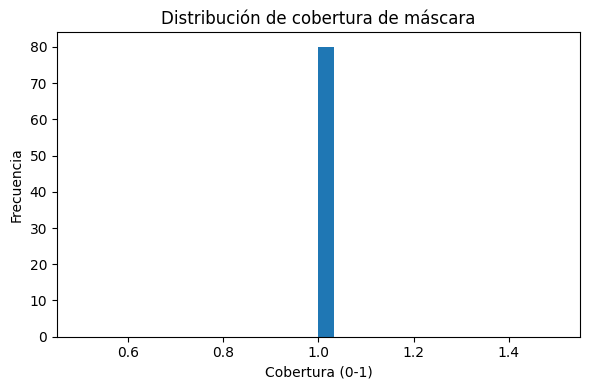

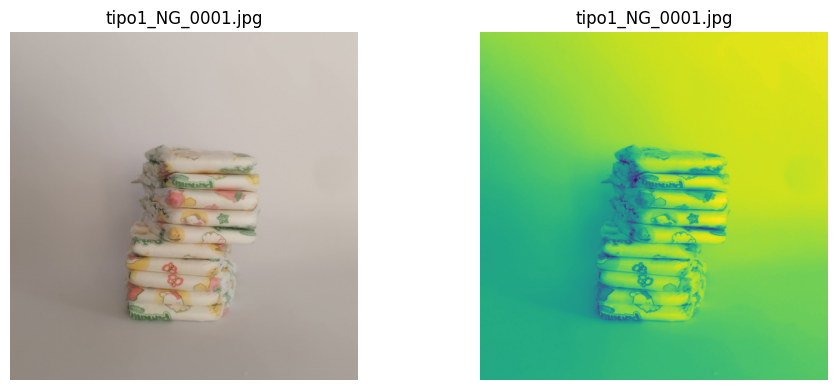

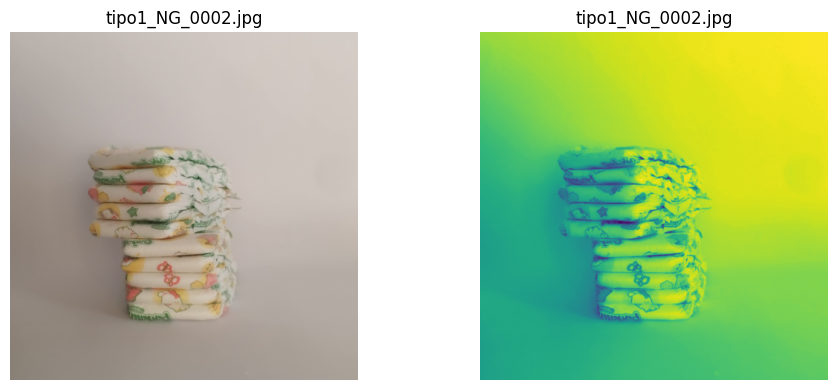

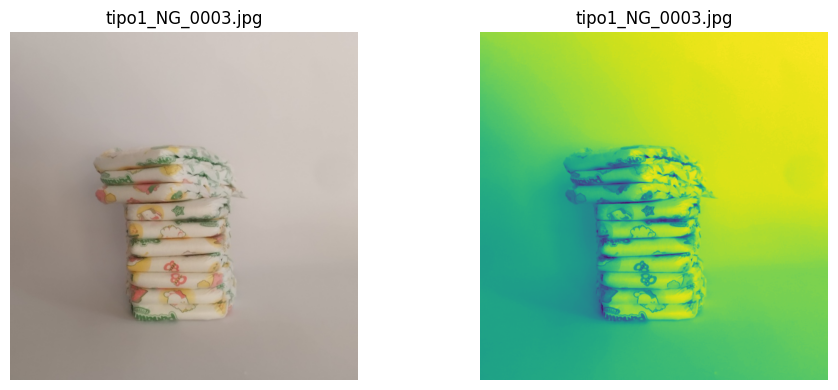


=== Anomalías Segmentación ===
Imágenes sin máscara: 0


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,mask_path,mask_coverage


Máscaras casi vacías (<=p1=1.000) y casi llenas (>=p99=1.000)


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,mask_path,mask_coverage
0,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,58761,175.354778,165.320083,155.790198,166.765401,32.886587,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
1,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61672,176.718542,166.378843,156.724167,167.879995,34.523157,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
2,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,59847,177.415769,166.435310,156.969580,168.086330,32.723040,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
3,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61135,173.885386,163.182036,154.662358,164.842448,46.404414,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
4,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,60574,173.334446,163.868684,154.643420,165.215041,35.123552,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,mask_path,mask_coverage
0,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,58761,175.354778,165.320083,155.790198,166.765401,32.886587,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
1,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61672,176.718542,166.378843,156.724167,167.879995,34.523157,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
2,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,59847,177.415769,166.435310,156.969580,168.086330,32.723040,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
3,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61135,173.885386,163.182036,154.662358,164.842448,46.404414,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
4,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,60574,173.334446,163.868684,154.643420,165.215041,35.123552,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0


Borrosas (<=p5=17.58): 4


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,mask_path,mask_coverage
18,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,56394,170.780037,163.686797,155.969243,164.637612,11.404858,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
44,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,58216,159.762991,149.576616,143.521052,151.305028,16.641514,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
49,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61047,167.358308,158.491226,150.123721,159.772233,16.809121,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0
52,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,70207,142.570684,133.858152,126.644924,135.189641,13.307004,None,/content/drive/MyDrive/Proyecto Final Maestria...,1.0



=== Conclusiones e insights (Segmentación) ===

- Verificar correspondencia 1:1 entre imágenes y máscaras.
- Revisar cobertura de máscaras; valores extremos suelen indicar etiquetado erróneo.
- Estandarizar tamaños/resoluciones (redimensionar y alinear máscaras).
- Aplicar augmentations consistentes imagen-máscara.



In [12]:
def read_mask(mask_path: Path):
    try:
        m = np.array(Image.open(mask_path))
        if m.ndim == 3:
            # si la máscara viene RGB, convertir a gris
            m = cv2.cvtColor(m, cv2.COLOR_RGB2GRAY)
        return m
    except Exception:
        return None

if MODE == "segmentation":
    img_files = [str(p) for p in SEG_IMG_DIR.rglob("*") if p.suffix.lower() in IMG_EXTS]
    df = pd.DataFrame({"filepath": img_files})
    stats = df["filepath"].apply(basic_image_stats)
    cols = ["width","height","aspect_ratio","file_size","mean_r","mean_g","mean_b","brightness","blur_var","phash"]
    df = pd.concat([df, pd.DataFrame(stats.tolist(), columns=cols)], axis=1)

    # Vincular máscaras por nombre
    def mask_for(fp):
        p = Path(fp)
        stem = p.stem
        parent_dir = p.parent # Get the directory of the image file
        for ext in [".png", ".jpg", ".jpeg", ".tif"]:
            # Look for a mask file with the same stem in the same directory as the image
            cand = parent_dir / f"{stem}{ext}"
            if cand.exists():
                return str(cand)
        return None


    df["mask_path"] = df["filepath"].apply(mask_for)

    show("Exploración inicial (Segmentación)")
    print("Total de imágenes:", len(df))
    print("Imágenes con máscara:", int(df["mask_path"].notna().sum()))
    display(df.head())

    # Cobertura de máscara (% de pixeles > 0)
    coverages = []
    sample_pairs = []
    for i, r in df.iterrows():
        mp = r["mask_path"]
        if mp:
            mask = read_mask(Path(mp))
            if mask is not None:
                coverage = float((mask>0).sum())/mask.size
                coverages.append(coverage)
                if len(sample_pairs)<3:
                    sample_pairs.append((r["filepath"], mp))
            else:
                coverages.append(np.nan)
        else:
            coverages.append(np.nan)
    df["mask_coverage"] = coverages

    plt.figure(figsize=(6,4))
    plt.hist(df["mask_coverage"].dropna(), bins=30)
    plt.title("Distribución de cobertura de máscara")
    plt.xlabel("Cobertura (0-1)"); plt.ylabel("Frecuencia")
    plt.tight_layout(); plt.show()

    # Vista rápida de 3 pares imagen-máscara
    for img_path, m_path in sample_pairs:
        img = cv2.cvtColor(cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = read_mask(Path(m_path))
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(img); plt.title(Path(img_path).name); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(mask); plt.title(Path(m_path).name); plt.axis("off")
        plt.tight_layout(); plt.show()

    # Anomalías típicas
    show("Anomalías Segmentación")
    missing_mask = df[df["mask_path"].isna()]
    print("Imágenes sin máscara:", len(missing_mask)); display(missing_mask.head(5))

    if "mask_coverage" in df.columns and df["mask_coverage"].notna().any():
        p1 = np.nanpercentile(df["mask_coverage"], 1)
        p99 = np.nanpercentile(df["mask_coverage"], 99)
        print(f"Máscaras casi vacías (<=p1={p1:.3f}) y casi llenas (>=p99={p99:.3f})")
        display(df[df["mask_coverage"]<=p1].head(5))
        display(df[df["mask_coverage"]>=p99].head(5))

    if imagehash is not None and "phash" in df.columns:
        ph_counts = df["phash"].value_counts()
        dup_hashes = ph_counts[ph_counts>1].index.tolist()
        dup_df = df[df["phash"].isin(dup_hashes)].sort_values("phash")
        print("Posibles duplicados pHash:", len(dup_df)); display(dup_df.head(10))

    if "blur_var" in df.columns and df["blur_var"].notna().any():
        p5 = np.nanpercentile(df["blur_var"], 5)
        print(f"Borrosas (<=p5={p5:.2f}):", int((df['blur_var']<=p5).sum()))
        display(df[df["blur_var"]<=p5].head(5))

    # Resumen
    show("Conclusiones e insights (Segmentación)")
    print("""
- Verificar correspondencia 1:1 entre imágenes y máscaras.
- Revisar cobertura de máscaras; valores extremos suelen indicar etiquetado erróneo.
- Estandarizar tamaños/resoluciones (redimensionar y alinear máscaras).
- Aplicar augmentations consistentes imagen-máscara.
""")

## 5C. Pipeline DETECCIÓN estilo YOLO (si `MODE='yolo'`)

In [8]:
# Definir variables necesarias
MODE = "yolo"  # Puedes cambiar a "detection" si es necesario
IMAGE_DIR = train_dir # o test_dir dependiendo de si quieres analizar el conjunto de entrenamiento o prueba
CLASS_FROM_PARENT = True # True si el nombre de la clase está en el nombre de la carpeta padre

# Definir extensiones de imagen válidas
IMG_EXTS = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]


--- Debugging Label Loading ---
--- Debugging Complete ---


=== Exploración inicial (YOLO) ===
Total de imágenes: 80
Total de objetos: 0


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,boxes,n_objects
0,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,58761,175.354778,165.320083,155.790198,166.765401,32.886587,None,[],0
1,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61672,176.718542,166.378843,156.724167,167.879995,34.523157,None,[],0
2,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,59847,177.415769,166.435310,156.969580,168.086330,32.723040,None,[],0
3,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61135,173.885386,163.182036,154.662358,164.842448,46.404414,None,[],0
4,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,60574,173.334446,163.868684,154.643420,165.215041,35.123552,None,[],0


,class_id,count


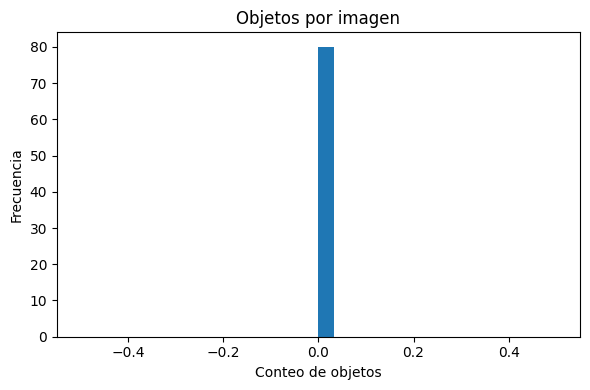


=== Anomalías YOLO ===
Imágenes sin etiquetas: 80


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,boxes,n_objects,bbox_areas
0,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,58761,175.354778,165.320083,155.790198,166.765401,32.886587,None,[],0,[]
1,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61672,176.718542,166.378843,156.724167,167.879995,34.523157,None,[],0,[]
2,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,59847,177.415769,166.435310,156.969580,168.086330,32.723040,None,[],0,[]
3,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61135,173.885386,163.182036,154.662358,164.842448,46.404414,None,[],0,[]
4,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,60574,173.334446,163.868684,154.643420,165.215041,35.123552,None,[],0,[]


Imágenes con bboxes fuera de rango: 0


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,boxes,n_objects,bbox_areas,bad_boxes


Borrosas (<=p5=17.58): 4


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,boxes,n_objects,bbox_areas,bad_boxes
18,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,56394,170.780037,163.686797,155.969243,164.637612,11.404858,None,[],0,[],0
44,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,58216,159.762991,149.576616,143.521052,151.305028,16.641514,None,[],0,[],0
49,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,61047,167.358308,158.491226,150.123721,159.772233,16.809121,None,[],0,[],0
52,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,70207,142.570684,133.858152,126.644924,135.189641,13.307004,None,[],0,[],0


Oscuras (<=p5=107.5) y Sobreexpuestas (>=p95=167.6)


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,boxes,n_objects,bbox_areas,bad_boxes
72,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,130107,74.776465,110.484255,146.442244,105.488946,109.928969,None,[],0,[],0
73,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,129901,73.238125,106.734712,139.392214,101.971209,124.101477,None,[],0,[],0
76,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,142986,73.056628,112.603740,149.556968,106.864047,147.817380,None,[],0,[],0
77,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.0,141799,73.638081,111.930266,149.911838,106.531617,146.788471,None,[],0,[],0


,filepath,width,height,aspect_ratio,file_size,mean_r,mean_g,mean_b,brightness,blur_var,phash,boxes,n_objects,bbox_areas,bad_boxes
1,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.00,61672,176.718542,166.378843,156.724167,167.879995,34.523157,None,[],0,[],0
2,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.00,59847,177.415769,166.435310,156.969580,168.086330,32.723040,None,[],0,[],0
24,/content/drive/MyDrive/Proyecto Final Maestria...,480,640,0.75,41512,179.150905,168.281582,160.398887,170.023269,45.789466,None,[],0,[],0
28,/content/drive/MyDrive/Proyecto Final Maestria...,640,640,1.00,60166,176.626201,167.896260,158.152290,169.048731,45.273403,None,[],0,[],0



=== Conclusiones e insights (YOLO) ===

- Verificar consistencia entre `images/` y `labels/` (faltantes).
- Revisar distribución de tamaños de bbox y conteo de objetos por imagen.
- Corregir coordenadas fuera de [0,1].
- Equilibrar clases si hay desbalance fuerte en `count`.
- Considerar augmentations por clase/tamaño de objeto.



In [9]:
def read_yolo_labels(lbl_path: Path):
    # Formato por línea: class_id x_center y_center width height  (normalizados 0-1)
    boxes = []
    try:
        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls = int(float(parts[0]))
                    x, y, w, h = map(float, parts[1:5])
                    boxes.append((cls, x, y, w, h))
        # print(f"Successfully read {len(boxes)} boxes from {lbl_path}") # Debugging print
    except Exception as e:
        # print(f"Error reading label file {lbl_path}: {e}") # Debugging print
        pass # Suppress errors during normal operation
    return boxes

if MODE == "yolo":
    # Define the base directory for images and labels
    YOLO_BASE_DIR = Path(train_dir) # Use the train_dir as the base

    # Define the path to the classes file (assuming it's in the dataset_dir)
    YOLO_CLASSES_FILE = Path(os.path.join(dataset_dir, 'classes.txt')) # Assuming a classes.txt file exists at the dataset_dir level


    # Check if the base directory exists before proceeding
    if not YOLO_BASE_DIR.exists():
        print(f"Error: YOLO base directory not found: {YOLO_BASE_DIR}")
    else:
        # List all image files within the base directory and its subdirectories (class folders)
        img_files = [str(p) for p in YOLO_BASE_DIR.rglob("*") if p.suffix.lower() in IMG_EXTS]
        df = pd.DataFrame({"filepath": img_files})

        if df.empty:
            print(f"No image files found in {YOLO_BASE_DIR}")
        else:
            # Stats básicas
            stats = df["filepath"].apply(basic_image_stats)
            cols = ["width","height","aspect_ratio","file_size","mean_r","mean_g","mean_b","brightness","blur_var","phash"]
            df = pd.concat([df, pd.DataFrame(stats.tolist(), columns=cols)], axis=1)

            # Cargar etiquetas
            label_map = {}
            if YOLO_CLASSES_FILE.exists():
                try:
                    classes = [c.strip() for c in open(YOLO_CLASSES_FILE, "r").read().splitlines() if c.strip()!=""]
                    label_map = {i:c for i,c in enumerate(classes)}
                    print(f"Loaded {len(classes)} classes from {YOLO_CLASSES_FILE}")
                except Exception as e:
                    print(f"Error loading classes file: {e}")
                    label_map = {}
            else:
                 print(f"Warning: Classes file not found at {YOLO_CLASSES_FILE}. Object class names will not be displayed.")


            ann_data = []
            print("\n--- Debugging Label Loading ---")
            for fp in df["filepath"]:
                p = Path(fp)
                lbl_path = p.with_suffix(".txt") # Look for .txt file with same stem in same directory

                # Debugging prints
                # print(f"Checking for label file: {lbl_path}")

                if lbl_path.exists():
                    # print(f"Label file found: {lbl_path}")
                    boxes = read_yolo_labels(lbl_path)
                    ann_data.append(boxes)
                    # if not boxes:
                        # print(f"No boxes read from existing label file: {lbl_path}") # Debugging print
                else:
                    ann_data.append([])
                    # print(f"Label file NOT found: {lbl_path}") # Debugging print
            print("--- Debugging Complete ---\n")


            df["boxes"] = ann_data
            df["n_objects"] = df["boxes"].apply(len)

            show("Exploración inicial (YOLO)")
            print("Total de imágenes:", len(df))
            print("Total de objetos:", int(df["n_objects"].sum()))
            display(df.head())

            # Conteo por clase
            cls_counts = Counter()
            for boxes in df["boxes"]:
                for (cls, x, y, w, h) in boxes:
                    cls_counts[cls] += 1
            cls_df = pd.DataFrame(sorted(cls_counts.items()), columns=["class_id","count"])
            if not cls_df.empty and label_map:
                cls_df["label"] = cls_df["class_id"].map(label_map)
            display(cls_df)

            # Histograma de objetos por imagen
            plt.figure(figsize=(6,4))
            plt.hist(df["n_objects"], bins=30)
            plt.title("Objetos por imagen")
            plt.xlabel("Conteo de objetos"); plt.ylabel("Frecuencia")
            plt.tight_layout(); plt.show()

            # Distribución de tamaños de bbox (área relativa)
            def bbox_area_stats(row):
                w = row["width"]; h = row["height"]
                areas = []
                if w>0 and h>0:
                    for (cls, xc, yc, bw, bh) in row["boxes"]:
                        areas.append(bw*bh)  # normalizado
                return areas

            df["bbox_areas"] = df.apply(bbox_area_stats, axis=1)
            all_areas = np.concatenate([np.array(a) for a in df["bbox_areas"] if len(a)>0]) if (df["bbox_areas"].map(len)>0).any() else np.array([])
            if all_areas.size>0:
                plt.figure(figsize=(6,4))
                plt.hist(all_areas, bins=30)
                plt.title("Distribución de áreas de bbox (relativas)")
                plt.xlabel("Área (0-1)"); plt.ylabel("Frecuencia")
                plt.tight_layout(); plt.show()

            # Muestra anotada (visualización)
            def draw_yolo_boxes(img_path, boxes, label_map=None):
                img = cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_COLOR)
                if img is None:
                    return None
                h, w = img.shape[:2]
                for (cls, xc, yc, bw, bh) in boxes:
                    x = int((xc - bw/2) * w)
                    y = int((yc - bh/2) * h)
                    ww = int(bw * w)
                    hh = int(bh * h)
                    cv2.rectangle(img, (x,y), (x+ww, y+hh), (255,0,0), 2)
                    cls_name = label_map.get(cls, str(cls)) if label_map else str(cls)
                    cv2.putText(img, cls_name, (x, max(0,y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                return img_rgb

            sample = df[df["n_objects"]>0].head(3)
            for _, r in sample.iterrows():
                vis = draw_yolo_boxes(r["filepath"], r["boxes"], label_map)
                if vis is not None:
                    plt.figure(figsize=(6,4))
                    plt.imshow(vis); plt.title(Path(r["filepath"]).name); plt.axis("off"); plt.show()

            # Anomalías típicas
            show("Anomalías YOLO")
            # 1) archivos sin etiqueta
            no_label = df[df["n_objects"]==0]
            print("Imágenes sin etiquetas:", len(no_label)); display(no_label.head(5))

            # 2) bboxes fuera de rango (coordenadas normalizadas no en [0,1])
            def out_of_range(boxes):
                bad = 0
                for (cls, xc, yc, bw, bh) in boxes:
                    if not (0<=xc<=1 and 0<=yc<=1 and 0<=bw<=1 and 0<=bh<=1):
                        bad += 1
                return bad
            df["bad_boxes"] = df["boxes"].apply(out_of_range)
            bad = df[df["bad_boxes"]>0]
            print("Imágenes con bboxes fuera de rango:", len(bad)); display(bad.head(5))

            # 3) duplicados y calidad de imagen
            if imagehash is not None and "phash" in df.columns:
                ph_counts = df["phash"].value_counts()
                dup_hashes = ph_counts[ph_counts>1].index.tolist()
                dup_df = df[df["phash"].isin(dup_hashes)].sort_values("phash")
                print("Posibles duplicados pHash:", len(dup_df)); display(dup_df.head(10))

            if "blur_var" in df.columns and df["blur_var"].notna().any():
                p5 = np.nanpercentile(df["blur_var"], 5)
                blurry = df[df["blur_var"]<=p5]
                print(f"Borrosas (<=p5={p5:.2f}):", len(blurry)); display(blurry.head(5))

            if "brightness" in df.columns and df["brightness"].notna().any():
                low_b = np.nanpercentile(df["brightness"], 5)
                high_b = np.nanpercentile(df["brightness"], 95)
                print(f"Oscuras (<=p5={low_b:.1f}) y Sobreexpuestas (>=p95={high_b:.1f})")
                display(df[df["brightness"]<=low_b].head(5))
                display(df[df["brightness"]>=high_b].head(5))

            # Resumen
            show("Conclusiones e insights (YOLO)")
            print("""
- Verificar consistencia entre `images/` y `labels/` (faltantes).
- Revisar distribución de tamaños de bbox y conteo de objetos por imagen.
- Corregir coordenadas fuera de [0,1].
- Equilibrar clases si hay desbalance fuerte en `count`.
- Considerar augmentations por clase/tamaño de objeto.
""")